___


Project: `Automatic Product Recommender (APR)`

Programmer: `@crispengari`

Date: `2022-05-10`

Abstract: `Automatic Product Recommender (APR) is a very useful topic in morden technologies. In this notebook we are going to create an Artificial Neural Network model using Deep Learning to detect weather the product is recommended or not based on review text and review upvotes. This model will be able to predict the rating of the product based on the features. APR is very usefull in moden technology because it helps product consumers to chose weather they should buy the product or not based on previous experinece customer reviews.`

Keywords: `tensorflow`, `embedding`, `keras`, `pandas`, `CNN`, `dataset`, `accuracy`, `nltk`, `loss`

Programming Language: `python`

Main: `Natural Language Processing (NLP)`

Main Package: `Tensorflow 2.*.*`

Dataset: [`kaggle`](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

____

### Automatic Product Recommender (APR)

In this notebook we are going to create a tensorflow model based on the keras subclassing api that will be able to predict two class labels:

1. `rating` - predict the ratting based on upvotes of the review text and the review text itself.
2. `recommend` - a binary label `0` or `1`, `1` if the product is recommended and `0` otherwise.

Our model will have two inputs which are:

1. `review text`
2. `upvotes`

### Dataset

The dataset that we are using was taken from [kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews). We are going to used the cleaned version of the dataset that was prepared in [this notebook](https://github.com/CrispenGari/APR-dl/blob/main/notebooks/00_E_Commerce_Clothing_Reviews_Data_Prep.ipynb).


### Installation of extra packages

In the following code cell we are going to install a package called `helperfns` which contains some usefull helper functions for machine learning that we are going to use throughout this notebook.

In [181]:
!pip install helperfns -q

### Basic imports

In the following code cell we are going to import all the packages that we are going to use in this notebook. We are also going to download some other files using `nltk`.

In [182]:
import os
import time
import random
import math
import nltk
import json
import urllib.request

import numpy as np
import tensorflow as tf
import pandas as pd
import wordcloud as wc

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from collections import Counter
from tensorflow import keras
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from google.colab import files, drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix
from sklearn.metrics import classification_report

nltk.download("punkt")

tf.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'2.15.0'

### Mounting the drive
In the following code cell we are going to mount the drive since we are loading the dataset from the google drive.

In [183]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Seed
We are going to set seed for reproducivity in the following code cell

In [184]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

### GPU Acceleration

We are going to make use of `GPU` if available so that we can increase the speed of mathematical computations in this notebook.

In [185]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
  print("No GPU's")

1 Physical GPUs, 1 Logical GPUs


### Data Path
In the following code cell we are going to define where our datafile path is. Note that this file is nothing but a `csv` file that is stored in my google drive.

In [186]:
data_path = "/content/drive/My Drive/NLP Data/E-Commerce Reviews/clean_data.csv"

assert os.path.exists(data_path) == True, "File not found"

### Dataframe
We are going to read the data_path as a dataframe using `pandas` in the following code cell.

In [187]:
dataframe = pd.read_csv(data_path)
dataframe.head(4)

,text,rating,recommended,upvotes
0,Absolutely wonderful silky and sexy and comfor...,4,1,0
1,Love this dress it is sooo pretty i happened t...,5,1,4
2,I had such high hopes for this dress and reall...,3,0,0
3,I love love love this jumpsuit it is fun flirt...,5,1,0


Before we spit the data into different sets we want to analyize how the data is distributed in our cleaned dataset. But before we do that we want to make sure that the text is in common case. So we are going to convert our text to lower case in the text column of our dataframe.

In [188]:
dataframe['text'] = dataframe['text'].apply(lambda x: x.lower())
dataframe.head(2)

,text,rating,recommended,upvotes
0,absolutely wonderful silky and sexy and comfor...,4,1,0
1,love this dress it is sooo pretty i happened t...,5,1,4


First let's visualize the using a line graph how the upvotes on a review text were distributed. In the following code cell we are going to do that.

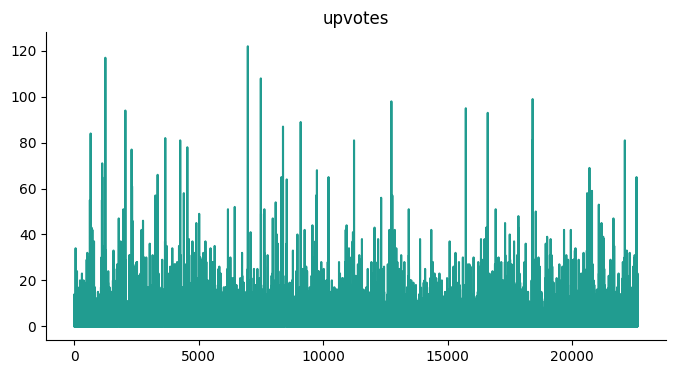

In [189]:
plt.figure(figsize=(4, 4))
dataframe['upvotes'].plot(kind='line', figsize=(8, 4), title='upvotes', color='#219C90')
plt.gca().spines[['top', 'right']].set_visible(False)

The above line graph shows the distribution of upvotes form a minimum of `0` on a review text to a maximum of `122`.

Next we are going to visualize how the ratings are distributed using a pie chat.


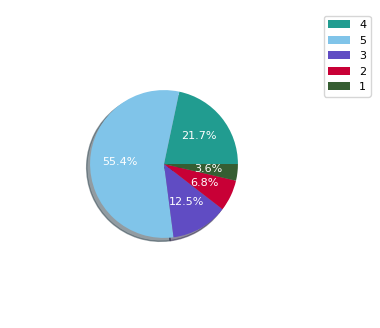

In [190]:
dist_rating	= {i:0 for i in dataframe.rating.unique()}
for rating in dataframe.rating:
  dist_rating[rating] += 1

plt.figure(figsize=(4, 4))
plt.pie(dist_rating.values(), labels=dist_rating.keys(),
        pctdistance=0.6, shadow=True, autopct='%1.1f%%', textprops={'color': 'white', 'fontsize':8}, radius=.6,
        colors=['#219C90', '#80C4E9', '#604CC3', '#C80036', '#365E32'])
plt.legend(fontsize=8, labels=list(dist_rating.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

From the above pie chat we can conclude that there are more `5` star ratted products that were reviewed. Only a fraction of `3.6%` were lowly rated. Since we will will be predicting the rating and we canm see that there is misbalance of labels accuracy metric will not be a good measure of how the model will perform. We are going to measure our model performance using other metrics such as the confusion matrix, f1_score, etc.



Next we are going to check how the labels were distributed interms of product recommentations.

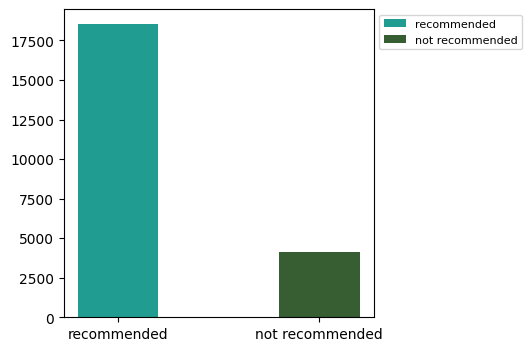

In [191]:
dist_recommended	= {'recommended': 0, 'not recommended': 0}
for recommended in dataframe.recommended:
  if recommended == 1:
    dist_recommended['recommended'] += 1
  else:
    dist_recommended['not recommended'] += 1

plt.figure(figsize=(4, 4))
plt.bar(dist_recommended.keys(), dist_recommended.values(), width=.4,label=dist_recommended.keys(),
        color=['#219C90', '#365E32'])
plt.legend(fontsize=8, labels=list(dist_recommended.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Most of the products that was reviewed by customers were recommended. We can see that there is a huge misbalance of data. What we want to do is to make sure that the labels will be balanced for recommended or not recommended, so our dataset will be trimmed a bit.


Let's check the context of the product reviews on women clothes. For that we are going to use a word cloud as a visualization to check which words were frequently appearing in the review text a lot based on the first `10_000` words in the review text.

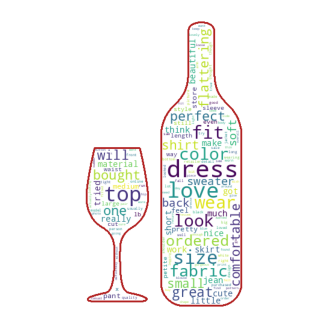

In [192]:
review_text = ' '.join(dataframe.text.values)

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

wine_mask = np.array(Image.open('wine.png')).astype(np.int32)
for i in range(len(wine_mask)):
    wine_mask[i] = list(map(transform_format, wine_mask[i]))

image = wc.WordCloud(background_color="white", max_words=10_000, mask=wine_mask,
                contour_width=3, contour_color='firebrick').generate(review_text)

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

We can see and conclude that the words like `dress`, `fabric`, `top` and `love` are frequently appearing in the review text. We can tell that these reviews was based on women clothing.


### Balancing labels

As i have mentioned we want to balance the rows of the recommended column. And check so that we can use a training accuracy as a measure of how our model will be good in predicting weather a product can be recommended to a customer or not based on the review text and review upvotes.

In [193]:
max_recommended = dataframe.recommended.where(dataframe.recommended == 0).count()
max_recommended

4101

We are going to balance our recommended labels to be equal.

In [194]:
dataframe = dataframe.groupby('recommended', as_index=False).apply(lambda x: x.sample(n=max_recommended)).reset_index(drop=True)
dataframe.head()

,text,rating,recommended,upvotes
0,luckily i bought this on sale i now see the in...,1,0,2
1,this dress is absolutely lovely i could not le...,5,0,8
2,i love love love byron lars dresses they fit m...,3,0,3
3,i tried this on today because when i touched i...,4,0,2
4,i love this dress but when i put it on i was a...,3,0,1


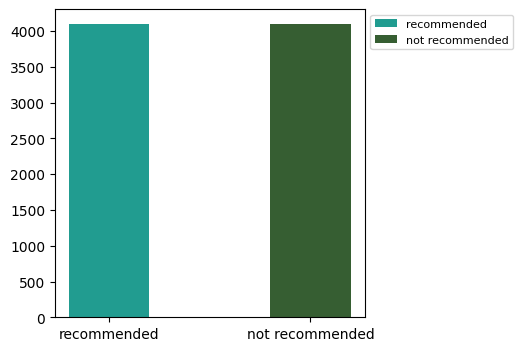

In [195]:
dist_recommended	= {'recommended': 0, 'not recommended': 0}
for recommended in dataframe.recommended:
  if recommended == 1:
    dist_recommended['recommended'] += 1
  else:
    dist_recommended['not recommended'] += 1

plt.figure(figsize=(4, 4))
plt.bar(dist_recommended.keys(), dist_recommended.values(), width=.4,label=dist_recommended.keys(),
        color=['#219C90', '#365E32'])
plt.legend(fontsize=8, labels=list(dist_recommended.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Now our recommended labels are balanced. Next we are going to check how the data is distributed in the ratings, upvotes and text columns.

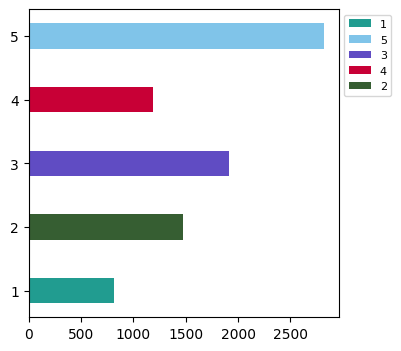

In [196]:
dist_rating	= {i:0 for i in dataframe.rating.unique()}
for rating in dataframe.rating:
  dist_rating[rating] += 1

plt.figure(figsize=(4, 4))
plt.barh(list(dist_rating.keys()), list(dist_rating.values()), height=.4,label=dist_rating.keys(),
        color=['#219C90', '#80C4E9', '#604CC3', '#C80036', '#365E32'])
plt.legend(fontsize=8, labels=list(dist_rating.keys()), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


Here is how the upvotes are now distributed after we have balanced the labels.

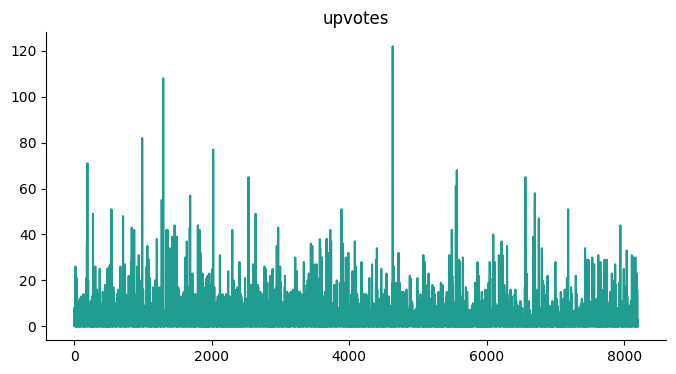

In [197]:
plt.figure(figsize=(4, 4))
dataframe['upvotes'].plot(kind='line', figsize=(8, 4), title='upvotes', color='#219C90')
plt.gca().spines[['top', 'right']].set_visible(False)

The above line graph shows the distribution of upvotes form a minimum of `0` on a review text to a maximum is now `117`.


Let's look at the most frequently words that appears in this dataset using word clouds.

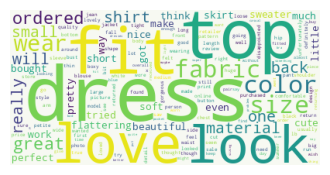

In [198]:
review_text = ' '.join(dataframe.text.values)

image = wc.WordCloud(background_color="#F7F9F2", max_words=10_000,
                contour_width=3, contour_color='firebrick').generate(review_text)

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

We can still see that the most occuring words in our dataset shows that for sure these reviews were based on women clothing.

### Splitting into subsets
In the following code cell we are going to split our dataset into 3 sets:

1. training
2. testing
3. validation


We are going to take `30%` for the test dataset and we are going to set the random state to the constant `SEED` for reproducivity and also for shuffling the rows of the dataset. On the validation set we are going to take another `50%` from the test data.

In [199]:
train_df, test_df= train_test_split(dataframe, random_state=SEED, test_size=.3)
test_df, val_df = train_test_split(test_df, random_state=SEED, test_size=.5)

### Counting examples

In the following code cell we are going to count how many example belongs to each set and visualize them inform of a table.

In [200]:
tabulate_data(["Set", "Total"],[
   ("training", len(train_df)),
    ("testing", len(test_df)),
    ("validation", len(val_df)),
], "Counting examples in the dataset.")

Counting examples in the dataset.
+------------+-------+
| Set        | Total |
+------------+-------+
| training   |  5741 |
| testing    |  1230 |
| validation |  1231 |
+------------+-------+


Next we are going to check the first 5 rows in the train dataset.

In [201]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

train_df.head()

,text,rating,recommended,upvotes
0,i buy almost ever top tiny puts out and so i g...,2,0,17
1,this dress was pretty but had a weird fit the ...,3,0,4
2,i like the colors material and style of this s...,3,0,0
3,i ordered this with another sweater to compare...,4,1,2
4,i wore this for a few hours and while it i got...,2,0,1


### Features and Lables
We have 2 features and 2 labels in our case. We are going to do some kind of preprocessing for these features and labels. First let's store all the values of features and labels in numpy arrays.

In [202]:
# Training
train_text = train_df.text.values
train_up_votes = train_df.upvotes.values
train_ratings = train_df.rating.values
train_recommends = train_df.recommended.values

# Validation
val_text = val_df.text.values
val_up_votes = val_df.upvotes.values
val_ratings = val_df.rating.values
val_recommends = val_df.recommended.values

# Testing
test_text = test_df.text.values
test_up_votes = test_df.upvotes.values
test_ratings = test_df.rating.values
test_recommends = test_df.recommended.values

### Labels processing

We are going to start by processing the labels. The labels are proccessed differently because we are doing both a binary classification and multi-label classification so they will have different activation functions.

### Ratings

Ratings start from `1` to `5` we want them to start from `0` to `4` and then `one_hot_encode` them. So that if the class label is `1` then the following will be the `one_hot_vector` for this label:

```
[0., 1., 0., 0., 0.]
```

In [203]:
train_ratings =  np.apply_along_axis(lambda x: x-1, 0, train_ratings)
val_ratings =  np.apply_along_axis(lambda x: x-1, 0, val_ratings)
test_ratings =  np.apply_along_axis(lambda x: x-1, 0, test_ratings)

In [204]:
one_hot_encode = lambda x: np.eye(5)[x]
one_hot_encode(1)

array([0., 1., 0., 0., 0.])

In [205]:
train_ratings =  np.apply_along_axis(one_hot_encode, 0, train_ratings)
val_ratings =  np.apply_along_axis(one_hot_encode, 0, val_ratings)
test_ratings =  np.apply_along_axis(one_hot_encode, 0, test_ratings)

In [206]:
train_ratings[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

### Recommends

Recoments labels are fine we don't need to do anything on them. We can check the few examples in the train set just to see if they are numbers `0` or `1`.

In [207]:
train_recommends[:5]

array([0, 0, 0, 1, 0])

### Text
Computers does not process text directly, we need to change the text to numbers by building a vocabulary which is a word to index mapping. After that we then going to pad the sequences of numbers or trancate the sequences that are longer so that by the end all the sequences should have the same size.

In [208]:
counter = Counter()
for sent in train_text:
  counter.update(word_tokenize(sent))

Checking the most common words

In [209]:
counter.most_common(10)

[('the', 20449),
 ('i', 16818),
 ('it', 12716),
 ('and', 11842),
 ('a', 10290),
 ('is', 9294),
 ('this', 6661),
 ('to', 6274),
 ('in', 5223),
 ('not', 5220)]

### The vocabulary size
We are going to use the train words to count how many unique words are there in the `counter` objects so that we can adapt to this.

In [210]:
vocab_size = len(counter)
vocab_size

9173

We have `~9K` unique words in our dictionary. In the following code cell we are going to create a tokenizer based on the vocab size that we obtained in the train data and make it adapt on our train text.

In [211]:
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words = vocab_size
)
tokenizer.fit_on_texts(train_text)

In [212]:
word_indices = tokenizer.word_index
word_indices_reversed = dict([(v, k) for (k, v) in word_indices.items()])

### Helper functions
1. `sequence_to_text`

This helper function will convert a sequence of integers to a sequence of text.

2. `text_to_sequence`

This helper function will convert the sequence of text to sequence of integers.

In [213]:
def sequence_to_text(sequences):
    return " ".join(word_indices_reversed[i] for i in sequences)

def text_to_sequence(sent):
  words = word_tokenize(sent.lower())
  sequences = []
  for word in words:
    try:
      sequences.append(word_indices[word])
    except:
      sequences.append(0)
  return sequences

### Creating sequences

We are then going to create sequences for all our 3 sets for the text in the following code cell.

In [214]:
train_sequence_tokens = tokenizer.texts_to_sequences(train_text)
test_sequence_tokens = tokenizer.texts_to_sequences(test_text)
val_sequence_tokens = tokenizer.texts_to_sequences(val_text)

In [215]:
sequence_to_text(train_sequence_tokens[1])

'this dress was pretty but had a weird fit the waist droops down in the middle instead of going straight across which i found unflattering i ended up returning it'

In [216]:
sequence_to_text(test_sequence_tokens[1])

'i really want to love this shirt but the small is just way too big on me for reference i am a d which is why i did not want to size down much more than a small and and i am drowning in this i am going to try it with different bottoms and ultimately will keep it because i do love the quality just size down a couple of sizes'

In [217]:
sequence_to_text(val_sequence_tokens[1])

'this sweater is big and box it looks very similar on as it does on the model as other reviewers have mentioned the embroidery on the shoulders is a bit itchy'

Having a closer look on these sequences they have different lenghts of which they must be padded or truncated so that they will have the same sequence length.This is done in the following code cell.

In [218]:
max_words = 100
train_tokens_sequence_padded = keras.preprocessing.sequence.pad_sequences(
                                       train_sequence_tokens,
                                       maxlen=max_words,
                                       padding="post",
                                       truncating="post"
                                       )
test_tokens_sequence_padded = keras.preprocessing.sequence.pad_sequences(
                                       test_sequence_tokens,
                                       maxlen=max_words,
                                       padding="post",
                                       truncating="post"
                                       )
val_tokens_sequence_padded = keras.preprocessing.sequence.pad_sequences(
                                       val_sequence_tokens,
                                       maxlen=max_words,
                                       padding="post",
                                       truncating="post"
                                       )

### Upvotes

Upvotes is a single number so we need to process them as inputs by doing the following.

1. first of all we need to expand the dimensions using numpy
2. we need to scale our upvotes features using `MinMaxScaler` from sklearn library

In [219]:
train_up_votes = np.expand_dims(train_up_votes, 1)
test_up_votes = np.expand_dims(test_up_votes, 1)
val_up_votes = np.expand_dims(val_up_votes, 1)

In [220]:
train_up_votes[:2]

array([[17],
       [ 4]])

In [221]:
scaler = MinMaxScaler()
scaler.fit(train_up_votes)

MinMaxScaler()

In [222]:
train_up_votes_scaled = scaler.transform(train_up_votes)
test_up_votes_scaled = scaler.transform(test_up_votes)
val_up_votes_scaled = scaler.transform(val_up_votes)

In [223]:
val_up_votes_scaled[:5]

array([[0.        ],
       [0.00925926],
       [0.        ],
       [0.        ],
       [0.        ]])

### Pretrained word Embeddings
We are going to load the `Glove.6B.100d` word vectors that was uploaded in the google drive as a `txt` file. These word embeddings vectors was trained on `~6B` words and are `100` dimension.

In [224]:
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"
assert os.path.exists(embedding_path) == True, "The path does not exists"

In [225]:
embeddings_dictionary = dict()
with open(embedding_path, encoding='utf8') as glove_file:
  for line in glove_file:
    records = line.split()
    word  = records[0]
    vectors = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vectors

Next we are going to create the embedding matrix that suits our data.

In [226]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  vector = embeddings_dictionary.get(word)
  if vector is not None:
    try:
      embedding_matrix[index] = vector
    except:
      pass

### Model

We are going to create a model using the `Sub Class API` from keras.


In [227]:
class APR(keras.Model):
  def __init__(self):
    super(APR, self).__init__()
    # layers for bidirectional
    forward_layer = keras.layers.GRU(
      128, return_sequences=True, dropout=.5,
      name="gru_forward_layer"
    )
    backward_layer = keras.layers.LSTM(
      128, return_sequences=True, dropout=.5,
      go_backwards=True, name="lstm_backward_layer"
    )
    self.embedding = keras.layers.Embedding(
          vocab_size, 100,
          input_length=max_words,
          weights=[embedding_matrix],
          trainable=True,
          name = "embedding_layer"
    )
    self.bidirectional = keras.layers.Bidirectional(
        forward_layer,
        backward_layer = backward_layer,
        name= "bidirectional_layer"
    )
    self.gru_layer = keras.layers.GRU(
              512, return_sequences=True,
              dropout=.5,
              name= "gru_layer"
      )
    self.lstm_layer = keras.layers.LSTM(
              512, return_sequences=True,
              dropout=.5,
              name="lstm_layer"
    )
    self.fc_1 = keras.layers.Dense(512, activation="relu", name="upvote_fc1")
    self.pooling_layer = keras.layers.GlobalAveragePooling1D(
          name="average_pooling_layer"
    )
    self.concatenate_layer = keras.layers.Concatenate(name="concatenate_layer_layer")

    self.dense_1 = keras.layers.Dense(64, activation='relu', name="dense_1")
    self.dropout_1 = keras.layers.Dropout(rate= .5, name="dropout_layer_0")
    self.dense_2 = keras.layers.Dense(512, activation='relu', name="dense_2")
    self.dropout_2 =  keras.layers.Dropout(rate= .5, name="dropout_layer_1")
    self.dense_3 = keras.layers.Dense(128, activation='relu', name="dense_3")
    self.dropout_3 = keras.layers.Dropout(rate= .5, name="dropout_layer_2")
    self.rating_output = keras.layers.Dense(5, activation='softmax', name="rating_output")
    self.recommend_output = keras.layers.Dense(1, activation='sigmoid', name="recommend_output")

  def call(self, inputs):
    text, upvote = inputs
    # Leaning the text features
    x_1 = self.embedding(text)
    x_1 = self.bidirectional(x_1)
    x_1 = self.gru_layer(x_1)
    x_1 = self.lstm_layer(x_1)
    x_1 = self.pooling_layer(x_1)

    # Learning the upvotes
    x_2 = self.fc_1(upvote)

    # concatenation
    x = self.concatenate_layer([x_1, x_2])

    # leaning combinned features
    x = self.dense_1(self.dropout_1(x))
    x = self.dense_2(self.dropout_2(x))
    x = self.dense_3(self.dropout_3(x))

    # outputs
    rating = self.rating_output(x)
    recommend = self.recommend_output(x)
    return rating, recommend

In [228]:
apr_model = APR()
apr_model.build([(None, 100), (None, 1)])
apr_model.summary()

Model: "apr_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  multiple                  917300    
 )                                                               
                                                                 
 bidirectional_layer (Bidir  multiple                  205568    
 ectional)                                                       
                                                                 
 gru_layer (GRU)             multiple                  1182720   
                                                                 
 lstm_layer (LSTM)           multiple                  2099200   
                                                                 
 upvote_fc1 (Dense)          multiple                  1024      
                                                                 
 average_pooling_layer (Glo  multiple                  0     

### Combiling the model
In the following code cell we are going to combile our model. Note that we have multiple labels which means we require 2 different activation functions. We are going to use the following loss functions:

1. `recommend_output` - `BinaryCrossentropy`
2. `rating_output` - `CategoricalCrossentropy`

For the optimizer we are going to use the `Adam` with default paramaters.


### Early Stopping
Early Stopping is a regularization technique that improves classification accuracy by intentionally stopping the training when `validation` loss increases. Training is stopped as training a model for too many epochs sometimes causes `Overfitting`. In Early Stopping, the number of epochs becomes a tunable hyperparameter.

In [229]:
recommend_output_early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_output_2_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)
rating_output_early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_output_1_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

apr_model.compile(
    loss = {
        "output_2" : keras.losses.BinaryCrossentropy(from_logits=False),
        "output_1" : keras.losses.CategoricalCrossentropy(from_logits=False)
    },
    metrics = ['accuracy'],
    optimizer = keras.optimizers.Adam()
)

### Training the model

In the following code cell we are going to train our model.


In [230]:
BATCH_SIZE = 128
EPOCHS = 50

history = apr_model.fit(
    x = [train_tokens_sequence_padded, train_up_votes_scaled],
    y = [train_ratings, train_recommends.astype('int32')],
    epochs = EPOCHS,
    verbose = 1,
    shuffle=True,
    batch_size= BATCH_SIZE,
    validation_data=([val_tokens_sequence_padded, val_up_votes_scaled], [val_ratings, val_recommends.astype('int32')]),
    validation_batch_size = BATCH_SIZE//2,
    callbacks =[recommend_output_early_stoping, rating_output_early_stoping]
)

Epoch 1/50
45/45 [==============================] - 22s 291ms/step - loss: 2.2151 - output_1_loss: 1.5269 - output_2_loss: 0.6881 - output_1_accuracy: 0.3379 - output_2_accuracy: 0.5307 - val_loss: 1.9817 - val_output_1_loss: 1.4029 - val_output_2_loss: 0.5788 - val_output_1_accuracy: 0.4167 - val_output_2_accuracy: 0.7465
Epoch 2/50
45/45 [==============================] - 8s 180ms/step - loss: 1.9460 - output_1_loss: 1.3873 - output_2_loss: 0.5587 - output_1_accuracy: 0.4335 - output_2_accuracy: 0.7354 - val_loss: 1.7254 - val_output_1_loss: 1.2706 - val_output_2_loss: 0.4547 - val_output_1_accuracy: 0.4639 - val_output_2_accuracy: 0.8067
Epoch 3/50
45/45 [==============================] - 8s 170ms/step - loss: 1.7204 - output_1_loss: 1.2626 - output_2_loss: 0.4578 - output_1_accuracy: 0.4677 - output_2_accuracy: 0.7898 - val_loss: 1.7745 - val_output_1_loss: 1.3228 - val_output_2_loss: 0.4517 - val_output_1_accuracy: 0.4549 - val_output_2_accuracy: 0.7904
Epoch 4/50
45/45 [=========

### Training history visualization
In the next code cell we are going to visualize the training history of our model interms of loss and accuracy.

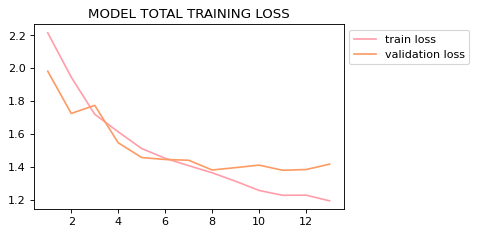

In [232]:

history = history.history
N_EPOCHS = len(history['loss'])
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history['loss'], label="train loss", color="#FF9EAA")
plt.plot(epochs, history['val_loss'], label="validation loss", color="#FD9B63")
plt.title("MODEL TOTAL TRAINING LOSS", color="k", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel = "epochs"
plt.show()


Next let's visualize the output train loss for the `recommended` and `rating` labels.

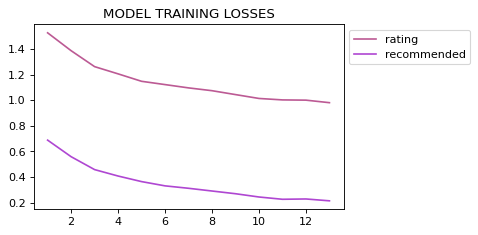

In [233]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history['output_1_loss'], label="rating", color="#BC5A94")
plt.plot(epochs, history['output_2_loss'], label="recommended", color="#AF47D2")
plt.title("MODEL TRAINING LOSSES", color="k", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel = "epochs"
plt.show()

Let's do the same for the `validation_loss`.

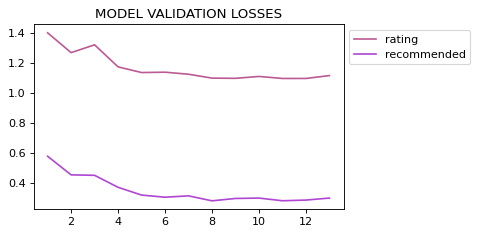

In [234]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history['val_output_1_loss'], label="rating", color="#BC5A94")
plt.plot(epochs, history['val_output_2_loss'], label="recommended", color="#AF47D2")
plt.title("MODEL VALIDATION LOSSES", color="k", fontsize=12)
plt.legend(fontsize=10,  bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel = "epochs"
plt.show()

Next we are going to visualize the train and validation accuracy of the `recommended` label. We don't care much about the accuracy of the `rating` label as it is not a good measure in this case because the labels were not balanced. So in that case we are going to skip visualizing it.

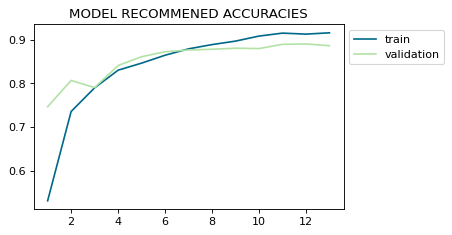

In [235]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history['output_2_accuracy'], label="train", color="#006989")
plt.plot(epochs, history['val_output_2_accuracy'], label="validation", color="#B3E2A7")
plt.title("MODEL RECOMMENED ACCURACIES", color="k", fontsize=12)
plt.legend(fontsize=10,  bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel = "epochs"
plt.show()

### Evaluating the Model

In the following code cell we are going to evaluate the `apr_model` based on the test dataset.

In [236]:
test_history = apr_model.evaluate(
    x = [test_tokens_sequence_padded, test_up_votes_scaled],
    y = [test_ratings, test_recommends.astype('int32')],
   verbose=1, batch_size=BATCH_SIZE//2
)

20/20 [==============================] - 1s 28ms/step - loss: 1.5554 - output_1_loss: 1.1667 - output_2_loss: 0.3887 - output_1_accuracy: 0.5081 - output_2_accuracy: 0.8642


In [237]:
tabulate_data(["Metric", "Value"],list(zip(
  ['loss', 'rating loss', 'recommended loss',  'rating acc', 'recommended acc',], [f"{i:.2f}" for i in test_history]
)), "Model test metrics.")

Model test metrics.
+------------------+-------+
| Metric           | Value |
+------------------+-------+
| loss             |  1.56 |
| rating loss      |  1.17 |
| recommended loss |  0.39 |
| rating acc       |  0.51 |
| recommended acc  |  0.86 |
+------------------+-------+


Next lets get all the predictions from our test dataset.

In [238]:
recommends_true = test_recommends.astype('int32')
ratings_true =  np.argmax(test_ratings, axis=1)

In [239]:
def predict_labels(inputs: list, model):
  rating_pred, recommend_pred = model.predict(inputs)
  rating_label = np.argmax(rating_pred, axis=1)
  recommended_label = np.array([1 if x >=0.5 else 0 for x in np.squeeze(recommend_pred)])
  return rating_label, recommended_label

ratings_prediction, recommends_prediction = predict_labels([test_tokens_sequence_padded, test_up_votes_scaled],apr_model)

39/39 [==============================] - 2s 14ms/step


### Confusion matrix.

In the following code cells we are going to create a confusion matrix as to measure how good our model was in predicting ratings and recommendation label using a `confustion matrix`. We are going to do this on our test dataset only.


First let's plot the confusion matrix for the recommended predictions.


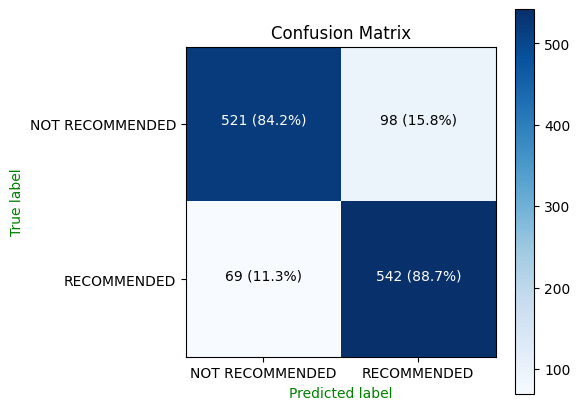

In [240]:
plot_complicated_confusion_matrix(recommends_true, recommends_prediction,
  ['NOT RECOMMENDED', 'RECOMMENDED'], fontsize=10, figsize=(5, 5)
)

In the next code cell we are going to plot the confusion matrix for the ratings prediction on the test dataset.

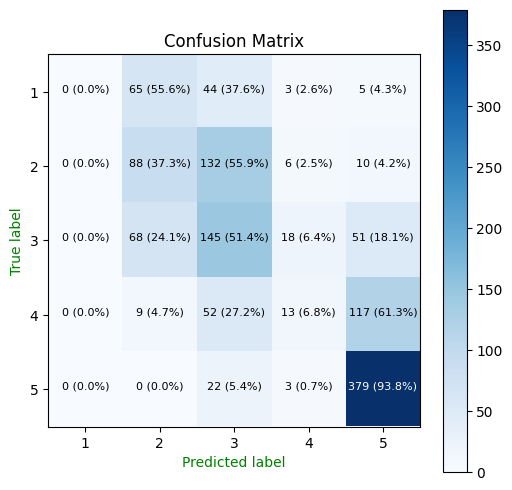

In [241]:
plot_complicated_confusion_matrix(ratings_true, ratings_prediction,
  [1, 2, 3, 4, 5], fontsize=8, figsize=(6, 6)
)

### Classification Report

In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting our labels. We will start by ploting the classification report of the `recommended`.

In [242]:
cr = classification_report(recommends_true, recommends_prediction, output_dict=False
                        )
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       619
           1       0.85      0.89      0.87       611

    accuracy                           0.86      1230
   macro avg       0.86      0.86      0.86      1230
weighted avg       0.87      0.86      0.86      1230



Then we show the classification report of the `ratings`

In [243]:
cr = classification_report(ratings_true, ratings_prediction, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.38      0.37      0.38       236
           2       0.37      0.51      0.43       282
           3       0.30      0.07      0.11       191
           4       0.67      0.94      0.78       404

    accuracy                           0.51      1230
   macro avg       0.35      0.38      0.34      1230
weighted avg       0.43      0.51      0.45      1230



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Inference

In the following code cell we are going to create a function that will make product recommentations based on two inputs:

1. text_review
2. text_review_upvote

So the pipeline for all our features will be the same as what we did in during training.

In [244]:
def apr_predictor(text_review: str, text_review_upvote:int, model):
  recomment_classes =["NOT RECOMMENDED", "RECOMMENDED"]
  recomment_emoji = ["👎", "👍"]
  tokens = text_to_sequence(text_review)
  padded_tokens = keras.preprocessing.sequence.pad_sequences([tokens],
                                maxlen=max_words,
                                padding="post",
                                truncating="post"
                                )

  text_review_upvote = scaler.transform([text_review_upvote])
  inputs = [padded_tokens, text_review_upvote]
  rating_pred, recommend_pred = model.predict(inputs)

  rating_pred = np.squeeze(rating_pred)
  rating_label = np.argmax(rating_pred)
  recomment_pred = tf.squeeze(recommend_pred).numpy()
  recomment_label = 1 if recomment_pred >=0.5 else 0
  probability = float(round(recomment_pred, 3)) if recomment_pred >= 0.5 else float(round(1 - recomment_pred, 3))

  pred_obj ={
      "recommend": {
        "label": recomment_label,
        "probability": probability,
        "class_": recomment_classes[recomment_label],
        "emoji": recomment_emoji[recomment_label]
      },
      "rating":{
          "rating": rating_label+1,
          "stars": "⭐" * (rating_label +1),
          "probability": float(round(rating_pred[rating_label], 3))
      }
  }
  return pred_obj

apr_predictor(test_text[0], test_up_votes[0], apr_model)

1/1 [==============================] - 0s 31ms/step


{'recommend': {'label': 1,
  'probability': 0.9959999918937683,
  'class_': 'RECOMMENDED',
  'emoji': '👍'},
 'rating': {'rating': 5, 'stars': '⭐⭐⭐⭐⭐', 'probability': 0.800000011920929}}

### Saving and downloading the model.

In the following code cell we are going to download and save our model as an `.h5` static file.

In [245]:
MODEL_NAME = 'apr-model.h5'
apr_model.save_weights(MODEL_NAME)

In [246]:
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Saving and downloading the vocabulary
In the following code cell we are going to save and download the vocabulary that we used as a `json` file.


In [247]:
with open('vocab.json', 'w') as f:
  json.dump(word_indices, f)

files.download('vocab.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [248]:
len(word_indices)

9168

In [249]:
vocab_size

9173

### Saving and downloading the `train_up_votes`

We need to save and download `train_up_votes` so that we will create a `scaler` that we will use during `up_votes` preprocessing.

In [250]:
np.save('upvotes.npy', train_up_votes)
files.download('upvotes.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [251]:
train_text[0]

'i buy almost ever top tiny puts out and so i grabbed this one in the last tops sale since i am a sucker for embroidered flowers everything about it is gorgeous except it is so flimsy i can not even believe it like when i held it up in the dressing room i could see through the entire shirt front to back before even putting it on once on i could see everything through it i actually thought i was going to tear the thing to pieces trying it on it is so frail i own so many tiny shirts and while'

In [252]:
train_up_votes_scaled[0], train_ratings[0], train_recommends[0]

(array([0.15740741]), array([0., 1., 0., 0., 0.]), 0)

In [253]:
train_text[1]

'this dress was pretty but had a weird fit the waist droops down in the middle instead of going straight across which i found unflattering i ended up returning it'

In [254]:
train_up_votes[1], train_ratings[1], train_recommends[1]

(array([4]), array([0., 0., 1., 0., 0.]), 0)